# 🤔 Ensemble Learning은 Imbalanced Data에도 효과가 있을까?

## Import libraries

In [602]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import datasets
# import fetch_california_housing as dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, accuracy_score
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader 
import copy
from datetime import datetime
import torch.nn.functional as F  
import sys

## Parameters

In [603]:
rand_seed = 512

## Dataset Distribution (Target Y) 확인

- Dataset을 확인하여 Imbalanced Data인지 확인하기 

In [604]:
def view_distribution(y):
    # View distribution
    sns.distplot(y)
    plt.xlabel('x values')
    plt.ylabel('Frequency')

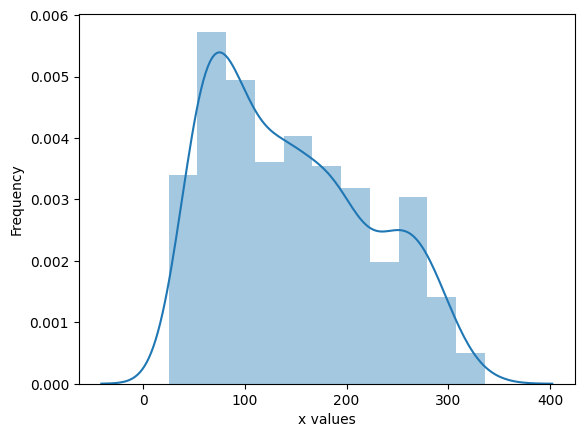

In [605]:
dataset_name = 'diabetes'
# dataset_name = 'california_house'

if dataset_name == 'diabetes':
    x, y= datasets.load_diabetes(return_X_y=True)
    threshold_rare = 270
elif dataset_name == 'california_house':
    data = datasets.fetch_california_housing()
    x = data.data
    y = data.target
    threshold_rare = 3.5

np.random.seed(seed=rand_seed)
sample = np.random.choice(range(len(y)), 500)
x_sample, y_sample = x[sample,:], y[sample]


view_distribution(y_sample)


In [606]:
print("X shape")
print(x.shape)
print("Y shape")
print(y.shape)


X shape
(442, 10)
Y shape
(442,)


In [607]:
# split the dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=rand_seed, train_size=0.8)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, random_state=rand_seed, train_size=0.8)

In [608]:
# scaling by minmax scaler
scaler = MinMaxScaler()
# scaler = StandardScaler()

scaler = scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_valid = scaler.transform(x_valid)

In [609]:
y

array([151.,  75., 141., 206., 135.,  97., 138.,  63., 110., 310., 101.,
        69., 179., 185., 118., 171., 166., 144.,  97., 168.,  68.,  49.,
        68., 245., 184., 202., 137.,  85., 131., 283., 129.,  59., 341.,
        87.,  65., 102., 265., 276., 252.,  90., 100.,  55.,  61.,  92.,
       259.,  53., 190., 142.,  75., 142., 155., 225.,  59., 104., 182.,
       128.,  52.,  37., 170., 170.,  61., 144.,  52., 128.,  71., 163.,
       150.,  97., 160., 178.,  48., 270., 202., 111.,  85.,  42., 170.,
       200., 252., 113., 143.,  51.,  52., 210.,  65., 141.,  55., 134.,
        42., 111.,  98., 164.,  48.,  96.,  90., 162., 150., 279.,  92.,
        83., 128., 102., 302., 198.,  95.,  53., 134., 144., 232.,  81.,
       104.,  59., 246., 297., 258., 229., 275., 281., 179., 200., 200.,
       173., 180.,  84., 121., 161.,  99., 109., 115., 268., 274., 158.,
       107.,  83., 103., 272.,  85., 280., 336., 281., 118., 317., 235.,
        60., 174., 259., 178., 128.,  96., 126., 28

In [610]:
y_train = y_train.reshape(-1, 1)
y_valid = y_valid.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [611]:
y.reshape(-1,1).shape

(442, 1)

In [612]:
print("num train : ", len(y_train))
print("num valid : ", len(y_valid))
print("num test  : ", len(y_test))

num train :  282
num valid :  71
num test  :  89


## General ANN

In [613]:
EPOCHS = 3500
BATCH_SIZE = 2048 
LEARNING_RATE = 0.001

NUM_INPUT = x_train.shape[1]
NUM_OUTPUT = 1 
NUM_1ST_HIDDEN = 32 
NUM_2ND_HIDDEN = 16 
NUM_1ST_DROPOUT = 0.6
NUM_2ND_DROPOUT = 0.5

In [614]:
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)



class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    


In [615]:
train_data = TrainData(torch.FloatTensor(x_train), torch.FloatTensor(y_train))
valid_data = TrainData(torch.FloatTensor(x_valid), torch.FloatTensor(y_valid))
test_data = TestData(torch.FloatTensor(x_test))

train_loader = DataLoader(dataset=train_data, batch_size=2048, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=256)
valid_loader = DataLoader(dataset=valid_data, batch_size=1024)

In [616]:
class BasicRegressor(nn.Module):
    def __init__(self) -> None:
        super(BasicRegressor, self).__init__()

        self.layer_1 = nn.Linear(NUM_INPUT, NUM_1ST_HIDDEN)
        self.layer_2 = nn.Linear(NUM_1ST_HIDDEN, NUM_2ND_HIDDEN)
        self.layer_out = nn.Linear(NUM_2ND_HIDDEN, NUM_OUTPUT)

        # self.actvation = nn.ReLU()
        self.actvation_1 = nn.ReLU()
        self.actvation_2 = nn.ReLU()
        self.dropout_1 = nn.Dropout(p=NUM_1ST_DROPOUT)
        self.dropout_2 = nn.Dropout(p=NUM_2ND_DROPOUT)
        self.batchnorm_1 = nn.BatchNorm1d(NUM_1ST_HIDDEN)
        self.batchnorm_2 = nn.BatchNorm1d(NUM_2ND_HIDDEN)
    
    def forward(self, inputs):
        x = self.actvation_1(self.layer_1(inputs))
        x = self.batchnorm_1(x)
        x = self.dropout_1(x)
        x = self.actvation_2(self.layer_2(x))
        x = self.batchnorm_2(x)
        x = self.dropout_2(x)
        x = self.layer_out(x)

        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
device='cpu'

cuda:0


In [617]:
model = BasicRegressor()
model.to(device)

print(model)


# criterion = nn.L1Loss()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

BasicRegressor(
  (layer_1): Linear(in_features=10, out_features=32, bias=True)
  (layer_2): Linear(in_features=32, out_features=16, bias=True)
  (layer_out): Linear(in_features=16, out_features=1, bias=True)
  (actvation_1): ReLU()
  (actvation_2): ReLU()
  (dropout_1): Dropout(p=0.6, inplace=False)
  (dropout_2): Dropout(p=0.5, inplace=False)
  (batchnorm_1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [618]:
def train_model(num_train_data, num_eval_data):

    best_loss_on_valid = 999999999
    best_model = None

    for epoch in range(1, EPOCHS+1):
        epoch_loss = 0
        epoch_acc = 0

        eval_epoch_loss = 0
        eval_epoch_acc = 0

        model.train()
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()

            y_pred = model(x_batch)

            loss = criterion(y_pred, y_batch)
        # acc = calc_accuracy(y_pred, y_batch)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        # epoch_acc += acc.item()
    
        if epoch % 10 == 0:
            with torch.no_grad():
                model.eval()
                for x, y in valid_loader:
                    x = x.to(device)
                    y = y.to(device)

                    output = model(x)

                    eval_loss = criterion(output, y)
                # eval_acc = calc_accuracy(output, y)

                    eval_epoch_loss += eval_loss.item()
                # eval_epoch_acc += eval_acc.item()
        
            if best_loss_on_valid >= (eval_epoch_loss/num_eval_data):
                best_loss_on_valid = (eval_epoch_loss/num_eval_data)
                best_model = copy.deepcopy(model)
                print("Best Model is copied - Best Loss : ", best_loss_on_valid)
        


            print(f"Epoch {epoch+0:03}: : Loss: T_{epoch_loss/num_train_data:.3f} V_{eval_epoch_loss/num_eval_data:.3f} | Acc: T_{epoch_acc/num_train_data:.3f}) V_{eval_epoch_acc/num_eval_data:.3f}")
    return best_model


In [619]:
def calc_loss(y_pred, y_test):
    mse_criterion = nn.L1Loss() 
    mse = mse_criterion(y_pred, y_test)

    return mse 

In [620]:
def calc_l1(y_pred, y_test):
    return np.abs(y_pred - y_test)

In [623]:
num_train_data = len(train_loader)
num_eval_data = len(valid_loader)


elapsed_time_basic_ann = []

start_time = datetime.now()


best_model = train_model(num_train_data, num_eval_data)


elapsed_time_basic_ann.append((datetime.now()-start_time).total_seconds())

Best Model is copied - Best Loss :  4854.703125
Epoch 010: : Loss: T_3610.938 V_4854.703 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  4755.359375
Epoch 020: : Loss: T_3816.199 V_4755.359 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  4683.79296875
Epoch 030: : Loss: T_3795.449 V_4683.793 | Acc: T_0.000) V_0.000
Epoch 040: : Loss: T_3342.872 V_4695.897 | Acc: T_0.000) V_0.000
Epoch 050: : Loss: T_3576.871 V_4724.002 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  4645.56787109375
Epoch 060: : Loss: T_3627.525 V_4645.568 | Acc: T_0.000) V_0.000
Epoch 070: : Loss: T_4201.196 V_4716.375 | Acc: T_0.000) V_0.000
Epoch 080: : Loss: T_4180.277 V_4703.083 | Acc: T_0.000) V_0.000
Epoch 090: : Loss: T_4017.960 V_4719.386 | Acc: T_0.000) V_0.000
Epoch 100: : Loss: T_3343.586 V_4721.548 | Acc: T_0.000) V_0.000
Epoch 110: : Loss: T_3777.028 V_4752.033 | Acc: T_0.000) V_0.000
Epoch 120: : Loss: T_3511.304 V_4823.896 | Acc: T_0.000) V_0.000
Epoch 130: : Loss: T_

In [624]:
best_model.eval()
data = torch.from_numpy(x_test).float().to(device)
answer = torch.from_numpy(y_test).float().to(device)

# data = torch.from_numpy(x_train).float().to(device)
# answer = torch.from_numpy(y_train_onehot).float().to(device)

# data = torch.from_numpy(x_valid).float().to(device)
# answer = torch.from_numpy(y_valid_onehot).float().to(device)

start_time = datetime.now()
output = best_model(data)
loss_basic_ann = calc_loss(output, answer)
elapsed_time_basic_ann.append((datetime.now()-start_time).total_seconds())

# print('Accuracy ', acc_basic_ann)
print('elapsed time ', elapsed_time_basic_ann)

elapsed time  [15.53642, 0.001251]


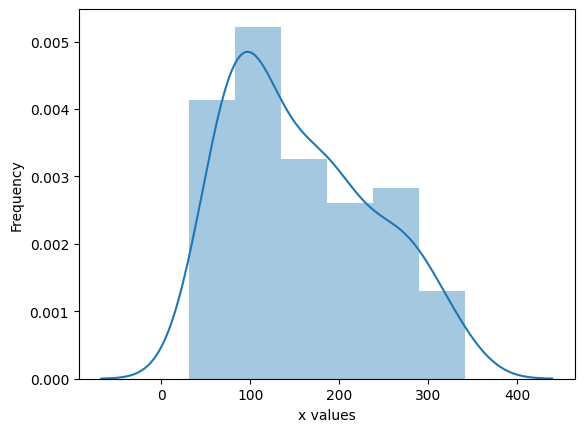

In [625]:
view_distribution(answer)

In [626]:
def calc_l1_loss_by_shots(output, answer):
    l1_loss = calc_l1(output, answer)
    rare_indicies = np.where(y_test>threshold_rare)[0]
    # print(rare_indicies)


    normal_indicies = np.where(y_test<=threshold_rare)[0]
    # print(normal_indicies)


    avg_rare_l1 = np.average(l1_loss[rare_indicies])
    avg_normal_l1 = np.average(l1_loss[normal_indicies])
    avg_total_l1 = np.average(l1_loss)

    return avg_rare_l1, avg_normal_l1, avg_total_l1

In [627]:
rare_loss, normal_loss, total_loss = calc_l1_loss_by_shots(output.detach().numpy(), answer.detach().numpy())
print("Rare Loss ", rare_loss)
print("Normal Loss ", normal_loss)
print("Total Loss ", total_loss)

Rare Loss  92.18011
Normal Loss  39.84448
Total Loss  46.900967


# Ensemble ANN

In [644]:
NUM_ENSEMBLE_MODELS = 6

In [645]:
best_models = []
for i in range(NUM_ENSEMBLE_MODELS):
    model = BasicRegressor()
    model.to(device)

    # criterion = nn.L1Loss()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    bagg_indices = np.random.choice(range(len(x_train)), len(x_train), replace=True)

    x_train_bagg = x_train[bagg_indices, :]
    y_train_bagg = y_train[bagg_indices, :]
    # train_data = TrainData(torch.FloatTensor(x_train), torch.FloatTensor(y_train))
    train_data = TrainData(torch.FloatTensor(x_train_bagg), torch.FloatTensor(y_train_bagg))
    train_loader = DataLoader(dataset=train_data, batch_size=2048, shuffle=True)


    num_train_data = len(train_loader)
    num_eval_data = len(valid_loader)


    elapsed_time_basic_ann = []
    start_time = datetime.now()

    best_model = train_model(num_train_data, num_eval_data)

    best_models.append(best_model)



Best Model is copied - Best Loss :  31848.21875
Epoch 010: : Loss: T_26657.176 V_31848.219 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  31774.376953125
Epoch 020: : Loss: T_26603.459 V_31774.377 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  31728.28515625
Epoch 030: : Loss: T_26607.461 V_31728.285 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  31701.048828125
Epoch 040: : Loss: T_26589.430 V_31701.049 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  31679.810546875
Epoch 050: : Loss: T_26553.770 V_31679.811 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  31651.96875
Epoch 060: : Loss: T_26506.652 V_31651.969 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  31624.3125
Epoch 070: : Loss: T_26513.510 V_31624.312 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  31591.384765625
Epoch 080: : Loss: T_26444.135 V_31591.385 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  31564.087890625
Epoch 090:

In [648]:
# inference
sum_output = np.zeros(y_test.shape)

for best_model in best_models:
    best_model.eval()
    output = best_model(data)
    sum_output += output.detach().numpy()

avg_output = sum_output / len(best_models)


In [649]:
rare_loss, normal_loss, total_loss = calc_l1_loss_by_shots(avg_output, answer.detach().numpy())
print("Rare Loss ", rare_loss)
print("Normal Loss ", normal_loss)
print("Total Loss ", total_loss)

Rare Loss  90.60466670989992
Normal Loss  36.6066241243701
Total Loss  43.887259079722426


# Ensemble ANN with REBAGG (REsampling Bagging Method, 2018, P Branco)

In [650]:
NUM_ENSEMBLE_MODELS = 6

In [651]:
relevance_value = threshold_rare


In [652]:
rare_indicies = np.where(y_train>threshold_rare)[0]
normal_indicies = np.where(y_train<=threshold_rare)[0]

ov_rare_indicies = np.random.choice(range(len(rare_indicies)), len(normal_indicies), replace=True)

x_train_normal_bagg = x_train[normal_indicies, :]
y_train_normal_bagg = y_train[normal_indicies, :]


x_train_rare_bagg = x_train[ov_rare_indicies, :]
y_train_rare_bagg = y_train[ov_rare_indicies, :]



In [653]:
best_models = []
for i in range(NUM_ENSEMBLE_MODELS):
    model = BasicRegressor()
    model.to(device)

    # criterion = nn.L1Loss()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    bagg_indices = np.random.choice(range(len(x_train)), len(x_train), replace=True)
    # x_train_bagg = x_train[bagg_indices, :]
    # y_train_bagg = y_train[bagg_indices, :]

    rare_indicies = np.where(y_train>threshold_rare)[0]
    normal_indicies = np.where(y_train<=threshold_rare)[0]

    ov_rare_indicies = np.random.choice(range(len(rare_indicies)), len(normal_indicies), replace=True)

    x_train_normal_bagg = x_train[normal_indicies, :]
    y_train_normal_bagg = y_train[normal_indicies, :]


    x_train_rare_bagg = x_train[rare_indicies, :]
    y_train_rare_bagg = y_train[rare_indicies, :]


    x_train_total_bagg = np.append(x_train_normal_bagg, x_train_rare_bagg, axis=0)
    y_train_total_bagg = np.append(y_train_normal_bagg, y_train_rare_bagg, axis=0)

    

    
    # train_data = TrainData(torch.FloatTensor(x_train), torch.FloatTensor(y_train))
    train_data = TrainData(torch.FloatTensor(x_train_total_bagg), torch.FloatTensor(y_train_total_bagg))
    train_loader = DataLoader(dataset=train_data, batch_size=2048, shuffle=True)


    num_train_data = len(train_loader)
    num_eval_data = len(valid_loader)


    elapsed_time_basic_ann = []
    start_time = datetime.now()

    best_model = train_model(num_train_data, num_eval_data)

    best_models.append(best_model)



Best Model is copied - Best Loss :  31809.47265625
Epoch 010: : Loss: T_27584.117 V_31809.473 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  31728.5703125
Epoch 020: : Loss: T_27516.529 V_31728.570 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  31665.228515625
Epoch 030: : Loss: T_27501.004 V_31665.229 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  31600.890625
Epoch 040: : Loss: T_27455.826 V_31600.891 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  31544.732421875
Epoch 050: : Loss: T_27428.688 V_31544.732 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  31481.04296875
Epoch 060: : Loss: T_27383.965 V_31481.043 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  31440.837890625
Epoch 070: : Loss: T_27312.703 V_31440.838 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  31393.986328125
Epoch 080: : Loss: T_27288.891 V_31393.986 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  31347.2421875
Epoch

In [654]:
# inference
sum_output = np.zeros(y_test.shape)

for best_model in best_models:
    best_model.eval()
    output = best_model(data)
    sum_output += output.detach().numpy()

avg_output = sum_output / len(best_models)


In [655]:
rare_loss, normal_loss, total_loss = calc_l1_loss_by_shots(avg_output, answer.detach().numpy())
print("Rare Loss ", rare_loss)
print("Normal Loss ", normal_loss)
print("Total Loss ", total_loss)

Rare Loss  89.92431640625
Normal Loss  37.661736071367805
Total Loss  44.708376116520455


In [656]:
np.zero

AttributeError: module 'numpy' has no attribute 'zero'

In [575]:
output.shape

torch.Size([89, 1])

In [583]:

sum_output = np.zeros([output.shape[0], output.shape[1]])

In [584]:
sum_output.shape

(89, 1)

In [ ]:
best_models

[BasicRegressor(
   (layer_1): Linear(in_features=10, out_features=32, bias=True)
   (layer_2): Linear(in_features=32, out_features=16, bias=True)
   (layer_out): Linear(in_features=16, out_features=1, bias=True)
   (actvation_1): ReLU()
   (actvation_2): ReLU()
   (dropout_1): Dropout(p=0.5, inplace=False)
   (dropout_2): Dropout(p=0.5, inplace=False)
   (batchnorm_1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (batchnorm_2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 ),
 BasicRegressor(
   (layer_1): Linear(in_features=10, out_features=32, bias=True)
   (layer_2): Linear(in_features=32, out_features=16, bias=True)
   (layer_out): Linear(in_features=16, out_features=1, bias=True)
   (actvation_1): ReLU()
   (actvation_2): ReLU()
   (dropout_1): Dropout(p=0.5, inplace=False)
   (dropout_2): Dropout(p=0.5, inplace=False)
   (batchnorm_1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stat